In [2]:
import pandas as pd
import numpy as np
import matminer
import pymatgen
from pymatgen import Lattice, Structure, Molecule
from pymatgen.core import structure
from pymatgen import Lattice, Structure, Molecule

In [63]:
from matminer.data_retrieval.retrieve_MP import MPDataRetrieval
df_mp = MPDataRetrieval(api_key='oQOsKmcqWtAzP9wv').get_dataframe(criteria='Si', properties=['band_gap','bandstructure_uniform'])
df_mp

In [6]:
from time import sleep
from math import ceil

import pandas as pd
from tqdm import tqdm
from pymatgen.core.structure import Structure
from pymatgen.core.composition import Composition

# from matminer.utils.io import store_dataframe_as_json
from matminer.featurizers.conversions import DictToObject, \
    StructureToOxidStructure, StrToComposition, CompositionToOxidComposition
from matminer.data_retrieval.retrieve_MP import MPDataRetrieval, MPRestError


def convert_to_oxide_structure(df, structure_col_name="structure",
                               batch_size=1000):
    """
    Takes a dataframe with a pymatgen Structure column and adds oxidation data
    to it. If structure is not a proper object, will try to convert first.
    Args:
        df (pd.DataFrame): DataFrame with a column of Structure objects
        structure_col_name (str): The identifier of the structure column
        batch_size (int): Size of batches to process dataframe in
    Returns: (pd.DataFrame)
    """
    if batch_size is None:
        batch_size = len(df)

    if not isinstance(df[structure_col_name][0], Structure):
        df = DictToObject(
            target_col_id=structure_col_name, overwrite_data=True
        ).featurize_dataframe(df, structure_col_name)

    oxide_featurizer = StructureToOxidStructure(
            target_col_id=structure_col_name, overwrite_data=True
        )

    # Process in batches to give usable progress bar
    for i in tqdm(range(ceil(len(df) / batch_size)),
                  desc="Processing oxidation state of structures in batches"):
        start_index = i * batch_size
        end_index = start_index + batch_size

        df.iloc[start_index:end_index] = oxide_featurizer.featurize_dataframe(
            df.iloc[start_index:end_index], structure_col_name, pbar=False
        )

    return df


def convert_to_oxide_composition(df, composition_col_name="composition",
                                 batch_size=1000):
    """
    Takes a dataframe with a pymatgen Composition column and adds oxidation data
    to it. If composition is not a proper object, will try to convert first.
    Args:
        df (pd.DataFrame): DataFrame with a column of Composition objects
        composition_col_name (str): The identifier of the composition column
        batch_size (int): Size of batches to process dataframe in
    Returns: (pd.DataFrame)
    """
    if batch_size is None:
        batch_size = len(df)

    if not isinstance(df[composition_col_name][0], Composition):
        df = StrToComposition(
            target_col_id=composition_col_name, overwrite_data=True
        ).featurize_dataframe(df, composition_col_name)

    oxide_featurizer = CompositionToOxidComposition(
        target_col_id=composition_col_name, overwrite_data=True
    )

    # Process in batches to give usable progress bar
    for i in tqdm(range(ceil(len(df) / batch_size)),
                  desc="Processing oxidation state of compositions in batches"):
        start_index = i * batch_size
        end_index = start_index + batch_size

        df.iloc[start_index:end_index] = oxide_featurizer.featurize_dataframe(
            df.iloc[start_index:end_index], composition_col_name, pbar=False
        )

    return df


# Functions for generating static datasets from various database resources
def generate_mp(max_nsites=None, properties=None, write_to_csv=False,
                write_to_compressed_json=False, include_oxide_info=True):
    """
    Grabs all mp materials. This will create two csv/json.gz files:
        * mp_nostruct: All MP materials, not including structures
        * mp_all: All MP materials, including structures
    Args:
        max_nsites (int): The maximum number of sites to include in the query.
        properties (iterable of strings): list of properties supported by
            MPDataRetrieval
        write_to_csv (bool): whether to write resulting dataframe to csv
        write_to_compressed_json (bool): whether to write resulting
            dataframe to json.gz file
        include_oxide_info (bool): Whether to convert pymatgen objects to
            objects including oxidation state information
    Returns (pandas.DataFrame):
        retrieved/generated data without structure data
    """

    # Set default properties if None and ensure is a list
    if properties is None:
        properties = ['pretty_formula', 'e_above_hull', 'band_gap',
                      'total_magnetization', 'elasticity.elastic_anisotropy',
                      'elasticity.K_VRH', 'elasticity.G_VRH', 'structure',
                      'energy', 'energy_per_atom', 'formation_energy_per_atom']
    elif not isinstance(properties, list):
        properties = list(properties)

    # Pick columns to drop structure data from
    drop_cols = []
    for col_name in ["structure", "initial_structure"]:
        if col_name in properties:
            drop_cols.append(col_name)

    mpdr = MPDataRetrieval(api_key='oQOsKmcqWtAzP9wv')
    if max_nsites is not None:
        sites_list = [i for i in range(1, max_nsites + 1)]
    else:
        sites_list = [i for i in range(1, 101)] + [{"$gt": 100}]

    df = pd.DataFrame()
    for site_specifier in tqdm(sites_list, desc="Querying Materials Project"):
        # While loop to repeat queries if server request fails
        while True:
            try:
                site_response = mpdr.get_dataframe(
                    criteria={"nsites": site_specifier},
                    properties=properties, index_mpid=True
                )
                break

            except MPRestError:
                tqdm.write("Error querying materials project, "
                           "trying again after 5 sec")
                sleep(5)

        df = df.append(site_response)

    df.rename(columns={'elasticity.K_VRH': 'K_VRH',
                       'elasticity.G_VRH': 'G_VRH',
                       'pretty_formula': 'composition'},
              index=str, inplace=True)

    # Convert returned data to the appropriate
    # pymatgen Structure/Composition objects
    df = DictToObject(
        target_col_id="structure", overwrite_data=True
    ).featurize_dataframe(df, "structure")

    df = StrToComposition(
        target_col_id="composition", overwrite_data=True
    ).featurize_dataframe(df, "composition")

    if include_oxide_info:
        df = convert_to_oxide_structure(df)
        df = convert_to_oxide_composition(df)

    tqdm.write("DataFrame with {} entries created".format(len(df)))

    # Write data out to file if user so chooses
    if write_to_csv:
        df.to_csv("mp_all.csv")
        df.drop(drop_cols, axis=1, inplace=True)
        df.to_csv("mp_nostruct.csv")

    if write_to_compressed_json:
        store_dataframe_as_json(df, "mp_all.json.gz", compression="gz")
        df = df.drop(drop_cols, axis=1)
        store_dataframe_as_json(df, "mp_nostruct.json.gz", compression="gz")

    return df


def generate_elastic_tensor(write_to_csv=False, write_to_compressed_json=False,
                            include_oxide_info=True):
    """
    Grabs all materials with elasticity data.
    This will return a csv/json.gz file:
        * elastic_tensor_2018: All MP materials with elasticity data,
            including structures
    Args:
        write_to_csv (bool): whether to write resulting dataframe to csv
        write_to_compressed_json (bool): whether to write resulting
            dataframe to json.gz file
        include_oxide_info (bool): Whether to add oxidation info to pymatgen
            objects
    Returns (pandas.DataFrame):
        retrieved/generated data
    """

    # ignore mp-978085 as causes Python to
    # crash when performing Voronoi analysis.
    criteria = {
        "elasticity": {"$exists": True},
        'material_id': {'$ne': 'mp-978085'}
    }
    properties = ['structure', 'pretty_formula',
                  'elasticity.K_VRH', 'elasticity.G_VRH',
                  'elasticity.warnings'
                  ]

    df = pd.DataFrame()
    mpdr = MPDataRetrieval()

    # Iterate over each site number to ensure returned object isn't too large
    for site_num in tqdm([i for i in range(1, 101)] + [{"$gt": 100}],
                         desc="Querying MP"):
        criteria["nsites"] = site_num
        # While loop to repeat queries if server request fails
        while True:
            try:
                site_response = mpdr.get_dataframe(
                    criteria=criteria, properties=properties, index_mpid=True
                )
                break

            except MPRestError:
                tqdm.write("Error querying materials project, "
                           "trying again after 5 sec")
                sleep(5)

        df = df.append(site_response)

    df.rename(columns={'elasticity.K_VRH': 'K_VRH',
                       'elasticity.G_VRH': 'G_VRH',
                       'pretty_formula': 'composition'},
              index=str, inplace=True)

    tqdm.write("There are {} elastic entries on MP".format(
        df['K_VRH'].count()
    ))

    df = df[~(df["elasticity.warnings"].apply(bool))]
    df = df.drop(["elasticity.warnings"], axis=1)

    tqdm.write("There are {} elastic entries on MP with no warnings".format(
        df['K_VRH'].count()
    ))

    print(df.columns)

    # Convert returned data to the appropriate
    # pymatgen Structure/Composition objects
    df = DictToObject(
        target_col_id="structure", overwrite_data=True
    ).featurize_dataframe(df, "structure")

    df = StrToComposition(
        target_col_id="composition", overwrite_data=True
    ).featurize_dataframe(df, "composition")

    if include_oxide_info:
        df = convert_to_oxide_structure(df)
        df = convert_to_oxide_composition(df)

    print(df.describe())
    print(df.head())

    # Write data out to file if user so chooses
    if write_to_csv:
        df.to_csv("elastic_tensor_2018.csv")

    if write_to_compressed_json:
        store_dataframe_as_json(
            df, "elastic_tensor_2018.json.gz", compression="gz"
        )

    return df




Querying Materials Project:   1%|▌                                                     | 1/101 [00:03<05:57,  3.57s/it]

Querying Materials Project:   2%|█                                                     | 2/101 [00:16<10:31,  6.38s/it]

Querying Materials Project:   3%|█▌                                                    | 3/101 [00:26<12:10,  7.45s/it]

AttributeError: 'MPRestError' object has no attribute 'message'

In [14]:
from matminer.datasets.convenience_loaders import load_jarvis_dft_3d
df=load_jarvis_dft_3d(drop_nan_columns=["bulk modulus"])

Fetching jarvis_dft_3d.json.gz from https://ndownloader.figshare.com/files/13376507 to d:\anacoda\envs\machine\lib\site-packages\matminer\datasets\jarvis_dft_3d.json.gz


In [6]:
read_jarvis_data_wNA=pd.read_csv('jarvis_dft_data.csv')

In [3]:
read_jarvis_data=pd.read_csv('jarvis_dft_data_csvNA.csv')

In [4]:
read_jarvis_data

,Unnamed: 0,epsilon_x opt,epsilon_y opt,epsilon_z opt,structure,e_form,shear modulus,structure initial,jid,bulk modulus,gap tbmbj,epsilon_x tbmbj,epsilon_y tbmbj,epsilon_z tbmbj,mpid,gap opt,composition
0,75,21.0673,29.1228,17.6066,Full Formula (As4)\nReduced Formula: As\nabc ...,0.025,19.993,Full Formula (As4)\nReduced Formula: As\nabc ...,JVASP-11997,34.556,0.6495,15.0619,14.9875,12.4788,mp-158,0.0221,As4
1,80,13.8023,38.1854,35.5515,Full Formula (Cu4 H4 O4 F4)\nReduced Formula: ...,-1.184,25.667,Full Formula (Cu4 H4 O4 F4)\nReduced Formula: ...,JVASP-12002,78.478,0.0083,16.5818,61.5222,53.1874,mp-24242,0.0038,H4 O4 F4 Cu4
2,83,6.3933,6.9466,6.3796,Full Formula (Mo4 O12)\nReduced Formula: MoO3\...,-2.086,52.420,Full Formula (Mo4 O12)\nReduced Formula: MoO3\...,JVASP-12010,75.067,2.4642,5.2402,5.8492,5.3897,mp-510584,1.9202,O12 Mo4
3,92,6.0838,6.0838,6.5652,Full Formula (Ag2 I2)\nReduced Formula: AgI\na...,-0.204,5.947,Full Formula (Ag2 I2)\nReduced Formula: AgI\na...,JVASP-12023,17.478,2.7025,4.5320,4.5323,4.9101,mp-567809,1.2599,Ag2 I2
4,95,7.0316,6.3127,5.2274,Full Formula (Zr2 Br2 N2)\nReduced Formula: Zr...,-1.768,37.120,Full Formula (Zr2 Br2 N2)\nReduced Formula: Zr...,JVASP-12027,54.633,2.2441,6.0366,5.5260,4.6886,mp-570157,1.8723,Zr2 Br2 N2
5,96,4.6738,4.7460,4.7722,Full Formula (In2 Br6)\nReduced Formula: InBr3...,-0.830,9.047,Full Formula (In2 Br6)\nReduced Formula: InBr3...,JVASP-12028,16.378,3.7113,3.6685,3.7637,3.7977,mp-570219,2.3104,In2 Br6
6,99,5.0636,5.0798,4.9797,Full Formula (Y2 I6)\nReduced Formula: YI3\nab...,-1.473,7.687,Full Formula (Y2 I6)\nReduced Formula: YI3\nab...,JVASP-12033,12.578,2.8863,5.5443,5.5399,5.5646,mp-571442,2.6760,Y2 I6
7,103,2.8447,2.9459,2.7976,Full Formula (Al2 H2 O4)\nReduced Formula: AlH...,-2.430,73.973,Full Formula (Al2 H2 O4)\nReduced Formula: AlH...,JVASP-12038,110.656,6.9515,2.4188,2.4769,2.3750,mp-625055,5.1686,Al2 H2 O4
8,108,4.9033,5.1118,5.1243,Full Formula (Bi2 O2 F2)\nReduced Formula: BiO...,-1.969,38.960,Full Formula (Bi2 O2 F2)\nReduced Formula: BiO...,JVASP-12051,96.300,4.4734,3.6415,3.7771,3.7842,mp-759883,2.9829,Bi2 O2 F2
9,115,16.9750,14.0779,15.5189,Full Formula (Cu2 H2 O4)\nReduced Formula: CuH...,-0.716,43.800,Full Formula (Cu2 H2 O4)\nReduced Formula: CuH...,JVASP-12059,80.133,0.0117,17.6582,21.6400,18.3388,mp-996956,0.0087,Cu2 H2 O4


In [7]:
shear_mod=read_jarvis_data['shear modulus']
bulk_mod=read_jarvis_data['bulk modulus']
shear_mod_wNA=read_jarvis_data_wNA['shear modulus']
bulk_mod_wNA=read_jarvis_data_wNA['bulk modulus']

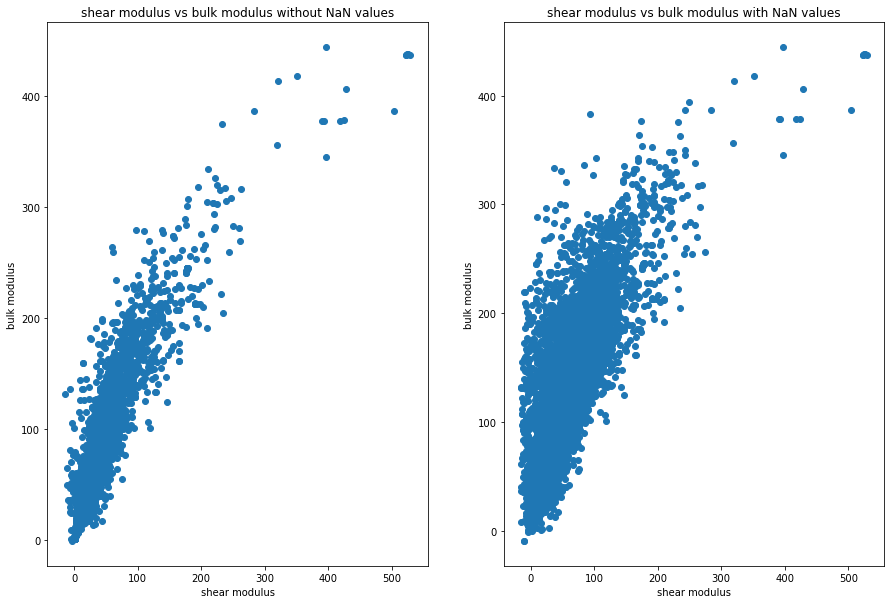

In [62]:
import matplotlib.pyplot as plt

fig1=plt.figure(figsize=(15,10))
p1=fig1.add_subplot(121)
p1.set_title('shear modulus vs bulk modulus without NaN values')
p1.scatter(shear_mod,bulk_mod)
plt.xlabel('shear modulus')
plt.ylabel('bulk modulus')

p1=fig1.add_subplot(122)
p1.set_title('shear modulus vs bulk modulus with NaN values')
p1.scatter(shear_mod_wNA,bulk_mod_wNA)

plt.xlabel('shear modulus')
plt.ylabel('bulk modulus')
# fig1.savefig('shear modulus vs bulk modulus')

In [22]:
delete_cols_list=['structure','structure initial','jid','mpid','composition']
def column_deletor(list_of_cols,data):
    temp=data
    temp=temp.drop(list_of_cols,axis=1)
    return temp

In [24]:
preprocessed_jarvis_data=column_deletor(delete_cols_list,read_jarvis_data)

In [48]:
preprocessed_jarvis_data=pd.read_csv('value_only_jarvisdata.csv')
preprocessed_jarvis_data=column_deletor(['Unnamed: 0','Unnamed: 0.1'],preprocessed_jarvis_data)

In [49]:
preprocessed_jarvis_data.head()

,epsilon_x opt,epsilon_y opt,epsilon_z opt,e_form,shear modulus,bulk modulus,gap tbmbj,epsilon_x tbmbj,epsilon_y tbmbj,epsilon_z tbmbj,gap opt
0,21.0673,29.1228,17.6066,0.025,19.993,34.556,0.6495,15.0619,14.9875,12.4788,0.0221
1,13.8023,38.1854,35.5515,-1.184,25.667,78.478,0.0083,16.5818,61.5222,53.1874,0.0038
2,6.3933,6.9466,6.3796,-2.086,52.420,75.067,2.4642,5.2402,5.8492,5.3897,1.9202
3,6.0838,6.0838,6.5652,-0.204,5.947,17.478,2.7025,4.5320,4.5323,4.9101,1.2599
4,7.0316,6.3127,5.2274,-1.768,37.120,54.633,2.2441,6.0366,5.5260,4.6886,1.8723


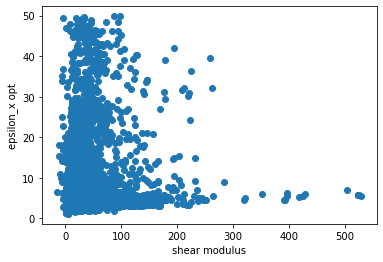

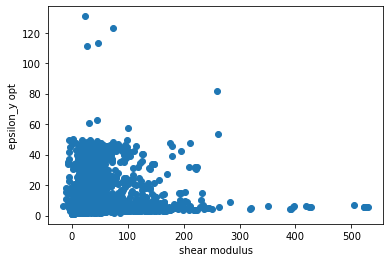

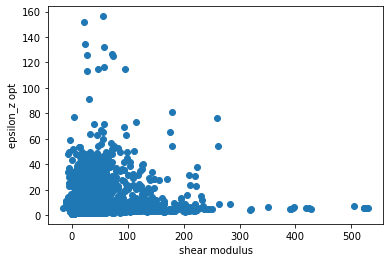

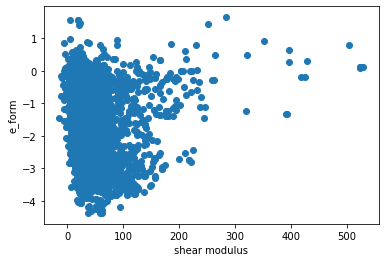

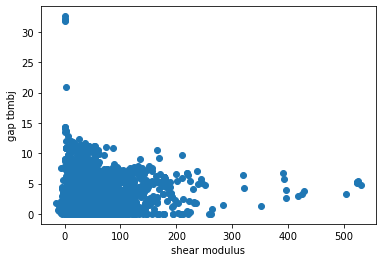

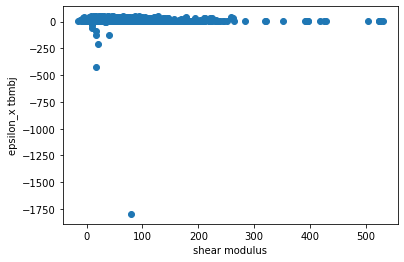

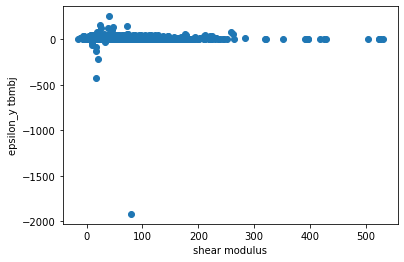

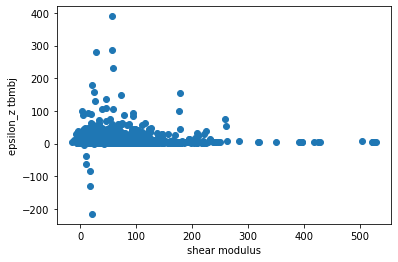

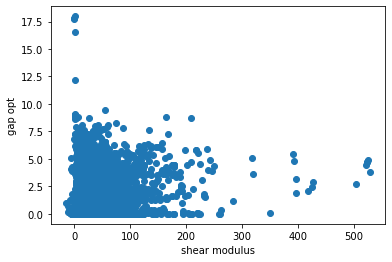

In [60]:
data_attributes=preprocessed_jarvis_data.columns
for column in data_attributes:
    if column == 'shear modulus' or column == 'bulk modulus':
        continue
    else:
        x_axis=preprocessed_jarvis_data['shear modulus']
        y_axis=preprocessed_jarvis_data[str(column)]
        plt.xlabel('shear modulus')
        plt.ylabel(str(column))
        plt.scatter(x_axis,y_axis)
#         st= 'shear modulus vs ' + str(column) + ' graph.png'
#         plt.savefig(st)
        plt.show()

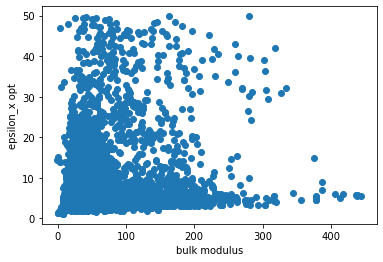

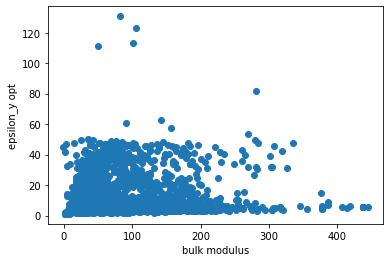

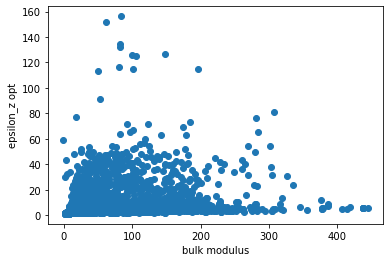

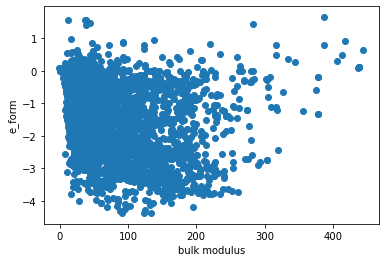

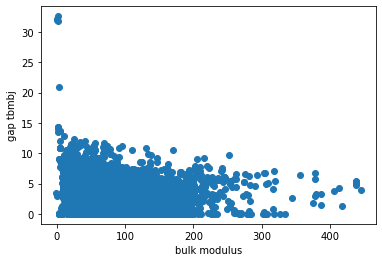

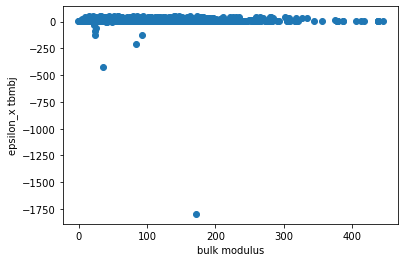

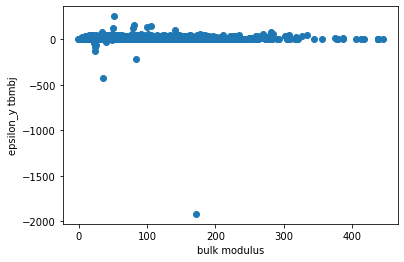

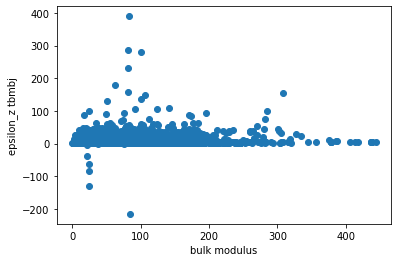

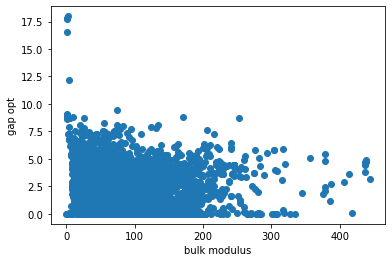

In [59]:
for column in data_attributes:
    if column == 'shear modulus' or column == 'bulk modulus':
        continue
    else:
        x_axis=preprocessed_jarvis_data['bulk modulus']
        y_axis=preprocessed_jarvis_data[str(column)]
        plt.xlabel('bulk modulus')
        plt.ylabel(str(column))
        plt.scatter(x_axis,y_axis)
#         st= 'bulk modulus vs ' + str(column) + ' graph.png'
#         plt.savefig(st)
        plt.show()

In [5]:
with open('jarvis_dft_3d.json', 'rb') as f:
    data = f.readlines()

In [7]:
data_json_str = "[" + ",".join(data) + "]"

# now, load it into pandas
data_df = pd.read_json(data_json_str)

TypeError: sequence item 0: expected str instance, bytes found

In [22]:
print(data[0][1000000:1100000])

b'4], [6.372497, -0.001057, 0.0], [-2.574938, 5.8291, 0.0]], "a": 3.786874, "b": 6.372497087661791, "c": 6.372496568366593, "alpha": 113.84239782402884, "beta": 90.0, "gamma": 90.0, "volume": 140.65662045182745}, "sites": [{"species": [{"element": "Cu", "occu": 1}], "abc": [0.5, 0.272595, 0.272595], "xyz": [1.0351955956049999, 1.588695381585, 1.893437], "label": "Cu"}, {"species": [{"element": "Cu", "occu": 1}], "abc": [0.0, 0.727405, 0.727405], "xyz": [2.762363404395, 4.239347618415, 0.0], "label": "Cu"}, {"species": [{"element": "Cl", "occu": 1}], "abc": [0.75, 0.627399, 0.372601], "xyz": [3.0386737715650005, 2.1712653283570003, 2.8401555], "label": "Cl"}, {"species": [{"element": "Cl", "occu": 1}], "abc": [0.25, 0.372601, 0.627399], "xyz": [0.7588852284350001, 3.6567776716430003, 0.9467185], "label": "Cl"}, {"species": [{"element": "O", "occu": 1}], "abc": [0.284562, 0.816573, 0.99819], "xyz": [2.6333316305609995, 5.817686211339001, 1.0776004391879999], "label": "O"}, {"species": [{

In [2]:
from matminer.datasets.dataset_retrieval import get_all_dataset_info
print(get_all_dataset_info())

TypeError: get_all_dataset_info() missing 1 required positional argument: 'dataset_name'